In [1]:
!pip install h5py

You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [2]:
import h5py

import sys
import os
import subprocess
import tarfile
import shutil
import random
from functools import partial
from tqdm import tqdm
from tqdm.auto import tqdm
tqdm.pandas()

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import (random_split, DataLoader, TensorDataset, ConcatDataset)
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits import mplot3d
from Bio import motifs
import pickle
from datetime import datetime
import scipy.stats as stats
import math

import boda
from boda.common import constants, utils

boda_src = os.path.join( os.path.dirname( os.path.dirname( os.getcwd() ) ), 'src' )
sys.path.insert(0, boda_src)

from main import unpack_artifact, model_fn
from pymeme import streme, parse_streme_output

from torch.distributions.categorical import Categorical
from boda.generator.plot_tools import matrix_to_dms, ppm_to_IC, ppm_to_pwm, counts_to_ppm

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:98% !important; }</style>"))

In [3]:
def dna2tensor_approx(sequence_str, vocab_list=constants.STANDARD_NT):
    seq_tensor = np.zeros((len(vocab_list), len(sequence_str)))
    for letterIdx, letter in enumerate(sequence_str):
        try:
            seq_tensor[vocab_list.index(letter), letterIdx] = 1
        except:
            seq_tensor[:, letterIdx] = 0
    seq_tensor = torch.Tensor(seq_tensor)
    return seq_tensor

def df_to_onehot_tensor(in_df, seq_column='nt_sequence'):
    onehot_sequences = torch.stack([dna2tensor_approx(subsequence) \
                                for subsequence in tqdm(in_df[seq_column])])
    return onehot_sequences

class mpra_predictor(nn.Module):
    def __init__(self,
                 model,
                 pred_idx=0,
                 ini_in_len=200,
                 model_in_len=600,
                 cat_axis=-1,
                 dual_pred=False):
        super().__init__()
        self.model = model
        self.pred_idx = pred_idx
        self.ini_in_len = ini_in_len 
        self.model_in_len = model_in_len
        self.cat_axis = cat_axis  
        self.dual_pred = dual_pred
        
        try: self.model.eval()
        except: pass
        
        self.register_flanks()
    
    def forward(self, x):
        pieces = [self.left_flank.repeat(x.shape[0], 1, 1), x, self.right_flank.repeat(x.shape[0], 1, 1)]
        in_tensor = torch.cat( pieces, axis=self.cat_axis)
        if self.dual_pred:
            dual_tensor = utils.reverse_complement_onehot(in_tensor)
            out_tensor = self.model(in_tensor)[:, self.pred_idx] + self.model(dual_tensor)[:, self.pred_idx]
            out_tensor = out_tensor / 2.0
        else:
            out_tensor = self.model(in_tensor)[:, self.pred_idx]
        return out_tensor
    
    def register_flanks(self):
        missing_len = self.model_in_len - self.ini_in_len
        left_idx = - missing_len//2 + missing_len%2
        right_idx = missing_len//2 + missing_len%2
        left_flank = utils.dna2tensor(constants.MPRA_UPSTREAM[left_idx:]).unsqueeze(0)
        right_flank = utils.dna2tensor(constants.MPRA_DOWNSTREAM[:right_idx]).unsqueeze(0)         
        self.register_buffer('left_flank', left_flank)
        self.register_buffer('right_flank', right_flank) 
        

def isg_contributions(sequences,
                      predictor,
                      num_steps=50,
                      num_samples=20,
                      eval_batch_size=1024,
                      theta_factor=15,
                      adaptive_sampling=False,
                      adaptive_spacing=False
                     ):
    
    batch_size = eval_batch_size // num_samples
    temp_dataset = TensorDataset(sequences)
    temp_dataloader = DataLoader(temp_dataset, batch_size=batch_size, shuffle=False, num_workers=2)
    
    if adaptive_sampling:
        if num_steps == 100: 
            sample_ns = np.flip((np.arange(0, num_steps)**0.615).astype(int)).clip(min=2)
        elif num_steps == 50:
            sample_ns = np.flip((np.arange(0, num_steps)**0.77).astype(int)).clip(min=2)
        else:
            print('Not possible to do adaptive sampling with this num_steps yet')
    else:
        sample_ns = [num_samples for i in range(0, num_steps + 1)]
        
    if adaptive_spacing:
        slope_coefficients = 1 / np.flip(20**(np.linspace(0, 1, num_steps)))
        slope_coefficients = slope_coefficients / slope_coefficients.max()
    else:
        slope_coefficients = [i / num_steps for i in range(1, num_steps + 1)]
    
    #all_salient_maps = []
    all_gradients = []
    for local_batch in tqdm(temp_dataloader):
        cuda_batch = local_batch[0].cuda()
        target_thetas = (theta_factor * cuda_batch).requires_grad_()
        line_gradients = []
        for i in range(0, num_steps):
            point_thetas = slope_coefficients[i] * target_thetas
            num_samples = sample_ns[i]
            point_distributions = F.softmax(point_thetas, dim=-2)
            nucleotide_probs = Categorical(torch.transpose(point_distributions, -2, -1))
            sampled_idxs = nucleotide_probs.sample((num_samples, ))
            sampled_nucleotides_T = F.one_hot(sampled_idxs, num_classes=4)
            sampled_nucleotides = torch.transpose(sampled_nucleotides_T, -2, -1)
            distribution_repeater = point_distributions.repeat(num_samples, *[1, 1, 1])
            sampled_nucleotides = sampled_nucleotides - distribution_repeater.detach() + distribution_repeater 
            samples = sampled_nucleotides.flatten(0,1)
            preds = predictor(samples)
            point_predictions = preds.unflatten(0, (num_samples, target_thetas.shape[0])).mean(dim=0)
            point_gradients = torch.autograd.grad(point_predictions.sum(), inputs=point_thetas, retain_graph=True)[0]
            line_gradients.append(point_gradients)

        gradients = torch.stack(line_gradients).mean(dim=0).detach()
        #all_salient_maps.append(gradients * target_thetas.detach())
        all_gradients.append(gradients)
        
    return theta_factor * torch.cat(all_gradients).cpu()
    # return torch.cat(all_salient_maps).cpu(), theta_factor * torch.cat(all_gradients).cpu()


def batch_to_contributions(onehot_sequences,
                           model,
                           model_output_len=3,
                           seq_len=200,
                           num_steps=50,
                           num_samples=20,
                           theta_factor=15,
                           eval_batch_size=1040,
                           adaptive_sampling=False,
                           adaptive_spacing=False):
    
    extended_contributions = []
    for i in range(model_output_len):
        predictor = mpra_predictor(model=model, pred_idx=i, ini_in_len=seq_len).cuda()
        extended_contributions.append(isg_contributions(onehot_sequences, predictor,
                                                        num_steps = num_steps,
                                                        num_samples=num_samples,
                                                        theta_factor=theta_factor,
                                                        eval_batch_size=eval_batch_size,
                                                        adaptive_sampling=adaptive_sampling,
                                                        adaptive_spacing=adaptive_spacing
                                                       ))
        
    #return torch.stack(extended_contributions, dim=-1)    
    return torch.stack(extended_contributions)  

### Load model

In [4]:
model_dir = './artifacts'
model = model_fn(model_dir)
#model.cuda()
model.eval()
print('')

Loaded model from 20211113_021200 in eval mode



### Get chunk

In [56]:
#f = h5py.File('genome_contribution_chunks/contribution_scores_created_202212_scores_contrib_test_chunk_1_of_1000.h5', 'r')
#f = h5py.File('genome_contribution_chunks/contribution_scores_created_202212_scores_contrib_test_chunk_14_of_1000.h5', 'r')
#f = h5py.File('genome_contribution_chunks/contribution_scores_created_202212_scores_contrib_test_chunk_8_of_1000.h5', 'r')

#f = h5py.File('genome_contribution_chunks/contrib_test_chunk_0_of_10000.h5', 'r')


#f = h5py.File('genome_contribution_chunks/contribution_scores_created_202212_scores_contrib_test_chunk_1_of_1000.h5', 'r')
#f = h5py.File('genome_contribution_chunks/contribution_scores_created_202212_scores_contrib_test_chunk_26_of_1000.h5', 'r')   #2?
#f = h5py.File('genome_contribution_chunks/contribution_scores_created_202212_scores_contrib_test_chunk_190_of_1000.h5', 'r')  #11, 12?
#f = h5py.File('genome_contribution_chunks/contribution_scores_created_202212_scores_contrib_test_chunk_280_of_1000.h5', 'r')   #18
#f = h5py.File('genome_contribution_chunks/contribution_scores_created_202212_scores_contrib_test_chunk_325_of_1000.h5', 'r')   #21
#f = h5py.File('genome_contribution_chunks/contribution_scores_created_202212_scores_contrib_test_chunk_490_of_1000.h5', 'r')   #34
#f = h5py.File('genome_contribution_chunks/contribution_scores_created_202212_scores_contrib_test_chunk_565_of_1000.h5', 'r')   #41
#f = h5py.File('genome_contribution_chunks/contribution_scores_created_202212_scores_contrib_test_chunk_640_of_1000.h5', 'r')   #43 
#f = h5py.File('genome_contribution_chunks/contribution_scores_created_202212_scores_contrib_test_chunk_736_of_1000.h5', 'r')   #49
#f = h5py.File('genome_contribution_chunks/contribution_scores_created_202212_scores_contrib_test_chunk_845_of_1000.h5', 'r')   #56
#f = h5py.File('genome_contribution_chunks/contribution_scores_created_202212_scores_contrib_test_chunk_890_of_1000.h5', 'r')   #58
#f = h5py.File('genome_contribution_chunks/contribution_scores_created_202212_scores_contrib_test_chunk_899_of_1000.h5', 'r')   #62
f = h5py.File('genome_contribution_chunks/contribution_scores_created_202212_scores_contrib_test_chunk_900_of_1000.h5', 'r')   #62

#f = h5py.File('genome_contribution_chunks/contribution_scores_created_202212_scores_contrib_test_chunk_930_of_1000.h5', 'r')   #N/A
#f = h5py.File('genome_contribution_chunks/contribution_scores_created_202212_scores_contrib_test_chunk_970_of_1000.h5', 'r')   #N/A
#f = h5py.File('genome_contribution_chunks/contribution_scores_created_202212_scores_contrib_test_chunk_990_of_1000.h5', 'r')   #N/A
#f = h5py.File('genome_contribution_chunks/contribution_scores_created_202212_scores_contrib_test_chunk_995_of_1000.h5', 'r')   #N/A
#f = h5py.File('genome_contribution_chunks/contribution_scores_created_202212_scores_contrib_test_chunk_998_of_1000.h5', 'r')   #N/A
#f = h5py.File('genome_contribution_chunks/contribution_scores_created_202212_scores_contrib_test_chunk_999_of_1000.h5', 'r')   #N/A

locations = f['locations'][:]
scores    = f['contribution_scores'][:]

# score axis names: ['windows', 'tokens', 'length', 'cells']

start = f'chr{locations[0][0] + 1}:{locations[0][1]}-{locations[0][2]}'
stop = f'chr{locations[-1][0] + 1}:{locations[-1][1]}-{locations[-1][2]}'
    
print(start, stop)
scores.shape

chr21:12082450-12082650 chr21:15185350-15185550


(62059, 4, 200, 3)

### Find corresponding genome chunk

In [57]:
chunk_idx = '62'

chunk_name = 'chunk_' + str(chunk_idx)#.zfill(2)
#print(chunk_name)
chunk_path = 'df_chunks/' + chunk_name + '.txt'

line_dict = {} 
with open(chunk_path, 'r') as f:
    for line in f:
        ID, sequence = line.lstrip('>::').rstrip('\n').split('\t')
        line_dict[ID] = sequence.upper()

list(line_dict.keys())[:2], list(line_dict.keys())[-2:]

(['chr1:0-200', 'chr21:8436550-8436750'],
 ['chr21:46709900-46709983', 'chr21:46709950-46709983'])

In [58]:
temp_df = pd.DataFrame(line_dict.items(), columns=['ID', 'nt_sequence'])
temp_df['seq_len'] = temp_df.apply(lambda x: len(x['nt_sequence']), axis=1)

temp_df

,ID,nt_sequence,seq_len
0,chr1:0-200,NNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNN...,200
1,chr21:8436550-8436750,CTCCCGGCCGCCGGGCGCGGGTCGGGCCGTCCGCCTCCTCGCGGGC...,200
2,chr21:8436600-8436800,GCGACGAAGAAGCGTCGCGGGTCTGTGGCGCGGGGCCCCGGTGGTC...,200
3,chr21:8436650-8436850,CGCGTGGGGGGCGGGTGGTTGGGGCGTCCGGTTCGCCGCGCCCCGC...,200
4,chr21:8436700-8436900,GCCCCACCGGTCCCGGCCGCCGCCCCCGCGCCCGCTCGCTCCCTCC...,200
...,...,...,...
765465,chr21:46709750-46709950,NNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNN...,200
765466,chr21:46709800-46709983,NNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNN...,183
765467,chr21:46709850-46709983,NNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNN...,133
765468,chr21:46709900-46709983,NNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNN...,83


In [59]:
start_idx, stop_idx = temp_df[temp_df['ID'] == start].index.item(), temp_df[temp_df['ID'] == stop].index.item()
batch_df = temp_df[start_idx : stop_idx + 1].reset_index(drop=True)
example_batch = df_to_onehot_tensor(batch_df)

start_idx, stop_idx

  0%|          | 0/62059 [00:00<?, ?it/s]

(72919, 134977)

In [60]:
len(batch_df), scores.shape[0]

(62059, 62059)

In [61]:
all_ns_sequence = 200*'N'
ns_seq_idxs = batch_df[(batch_df['nt_sequence'] == all_ns_sequence)].index.tolist()
len(ns_seq_idxs), scores[ns_seq_idxs, ...].sum()

(996, 0.0)

In [62]:
%%time

test_size = 50

all_ns_sequence = 200*'N'
# random_idxs = np.random.choice(batch_df[batch_df['nt_sequence'] != all_ns_sequence].index.tolist(),
#                                size=test_size, replace=False)
random_idxs = np.random.choice(batch_df[~batch_df['nt_sequence'].str.contains('N')].index.tolist(),
                               size=test_size, replace=False)
test_batch = example_batch[random_idxs, ...]
test_scores = scores[random_idxs, ...]
test_scores = torch.Tensor(test_scores).permute(3, 0, 1, 2)

result_dict = {}
#--- Standard high quality
n_steps   = 100
n_samples = 20
adaptive_sampling = False
adaptive_spacing  = False

out_contributions = batch_to_contributions(onehot_sequences=test_batch,
                                           model=model,
                                           num_steps=n_steps,
                                           num_samples=n_samples,
                                           adaptive_sampling=adaptive_sampling,
                                           adaptive_spacing=adaptive_spacing)

result_dict['Standard high quality'] = out_contributions

#--- Standard medium quality
n_steps   = 50
n_samples = 20
adaptive_sampling = False
adaptive_spacing  = False

out_contributions = batch_to_contributions(onehot_sequences=test_batch,
                                           model=model,
                                           num_steps=n_steps,
                                           num_samples=n_samples,
                                           adaptive_sampling=adaptive_sampling,
                                           adaptive_spacing=adaptive_spacing)

result_dict['Standard medium quality'] = out_contributions

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

CPU times: user 44.3 s, sys: 2.07 s, total: 46.4 s
Wall time: 46.2 s


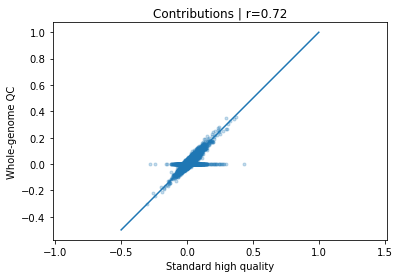

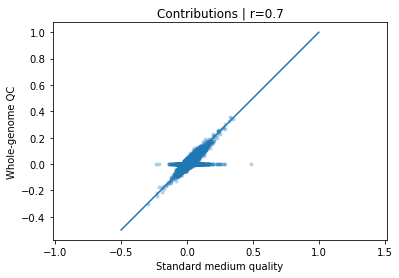

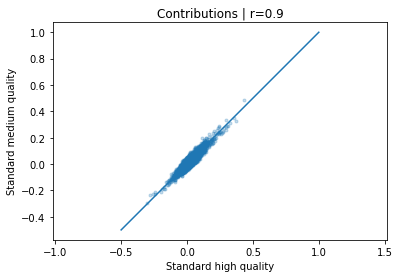

---- Extended contributions ----


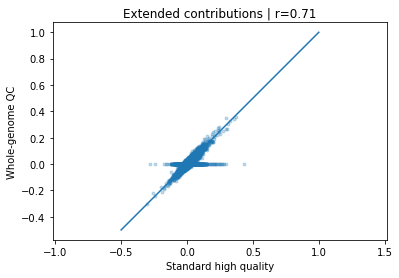

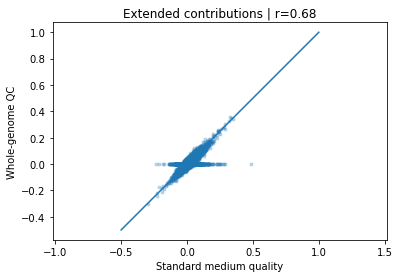

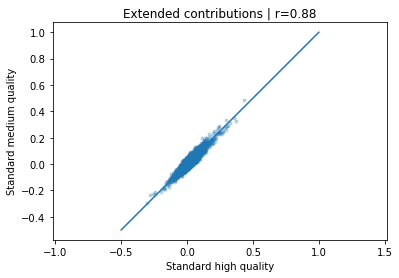

In [63]:
y = test_scores * test_batch.repeat(3,1,1,1)
y = y.sum(dim=2).flatten().numpy()
for key in result_dict.keys():
    x = result_dict[key] * test_batch.repeat(3,1,1,1)
    x = x.sum(dim=2).flatten().numpy()
    pearson = np.round(np.corrcoef(x,y)[0,1], 2)
    #print(key, pearson)
    
    plt.scatter(x=x, y=y, alpha=0.25, marker='.')
    plt.plot([-0.5, 1], [-0.5, 1])
    plt.axis('equal')
    plt.ylabel('Whole-genome QC')
    plt.xlabel(key)
    plt.title(f'Contributions | r={pearson}')
    plt.show()

x = result_dict['Standard high quality'] * test_batch.repeat(3,1,1,1)
x = x.sum(dim=2).flatten().numpy()
y = result_dict['Standard medium quality'] * test_batch.repeat(3,1,1,1)
y = y.sum(dim=2).flatten().numpy()
pearson = np.round(np.corrcoef(x,y)[0,1], 2)
#print(key, pearson)

plt.scatter(x=x, y=y, alpha=0.25, marker='.')
plt.plot([-0.5, 1], [-0.5, 1])
plt.axis('equal')
plt.xlabel('Standard high quality')
plt.ylabel('Standard medium quality')
plt.title(f'Contributions | r={pearson}')
plt.show()

print('---- Extended contributions ----')
    
y = test_scores.flatten().numpy()
for key in result_dict.keys():
    x = result_dict[key].flatten().numpy()
    pearson = np.round(np.corrcoef(x,y)[0,1], 2)
    #print(key, pearson)
    
    plt.scatter(x=x, y=y, alpha=0.25, marker='.')
    plt.plot([-0.5, 1], [-0.5, 1])
    plt.axis('equal')
    plt.ylabel('Whole-genome QC')
    plt.xlabel(key)
    plt.title(f'Extended contributions | r={pearson}')
    plt.show()

x = result_dict['Standard high quality'].flatten().numpy()
y = result_dict['Standard medium quality'].flatten().numpy()
pearson = np.round(np.corrcoef(x,y)[0,1], 2)
#print(key, pearson)

plt.scatter(x=x, y=y, alpha=0.25, marker='.')
plt.plot([-0.5, 1], [-0.5, 1])
plt.axis('equal')
plt.xlabel('Standard high quality')
plt.ylabel('Standard medium quality')
plt.title(f'Extended contributions | r={pearson}')
plt.show()

In [168]:
locations[random_idxs, :]

array([[      20, 13692300, 13692500,        1],
       [      20, 12454400, 12454600,        1],
       [      20, 12765800, 12766000,        1],
       [      20, 14061150, 14061350,        1],
       [      20, 14002400, 14002600,        1],
       [      20, 12276800, 12277000,        1],
       [      20, 12100450, 12100650,        1],
       [      20, 14645900, 14646100,        1],
       [      20, 14593950, 14594150,        1],
       [      20, 13289600, 13289800,        1],
       [      20, 14514300, 14514500,        1],
       [      20, 12792750, 12792950,        1],
       [      20, 14798150, 14798350,        1],
       [      20, 14998350, 14998550,        1],
       [      20, 14965000, 14965200,        1],
       [      20, 12520700, 12520900,        1],
       [      20, 12522450, 12522650,        1],
       [      20, 12106450, 12106650,        1],
       [      20, 13287200, 13287400,        1],
       [      20, 14928500, 14928700,        1],
       [      20, 13

In [176]:
temp_idxs = batch_df.iloc[random_idxs].index
temp_idxs

Int64Index([32197,  7439, 13667, 39574, 38399,  3887,   360, 51269, 50230,
            24143, 48637, 14206, 54314, 58318, 57651,  8765,  8800,   480,
            24095, 56921, 25550, 23898, 52557, 58596, 57200, 18798, 32532,
            28800, 30775,  3186, 20818, 38246, 50979, 47500, 47561, 38445,
             6981, 41976, 46889, 61288, 10219,  6691, 11660, 53704,  1685,
            58480, 35195, 42608, 31120, 52041],
           dtype='int64')

In [160]:
test_scores.shape

torch.Size([3, 50, 4, 200])

In [177]:
for i in range(50):
    if test_scores[:, i, :, :].sum() == 0.0:
        print(batch_df.iloc[temp_idxs[i]]['ID'])

chr21:12454400-12454600
chr21:12765800-12766000
chr21:12276800-12277000
chr21:12100450-12100650
chr21:12792750-12792950
chr21:12520700-12520900
chr21:12522450-12522650
chr21:12106450-12106650
chr21:12241750-12241950
chr21:12431500-12431700
chr21:12593400-12593600
chr21:12417000-12417200
chr21:12665450-12665650
chr21:12166700-12166900


In [18]:
batch_df.iloc[7439]['nt_sequence'] == 'GAGTTGAAGATTCCCTTTCATAGAGCACGTTTGAAACACTCTTTCTGGAGTATCTGGATGTGGACATTTGGAGCGCTTTGATGCCTACGGTGAAAAAGTAAATATCTTCCCATAAAAACGAGACAGAAGGATTCTGAGAAACAAGTTTGTGATGTGTGTACTCAGCTAACAGACTGGAACCTCTCTTTTGATGCAGCAGT'

True

In [15]:
batch_df.iloc[7439]

ID                                       chr21:12454400-12454600
nt_sequence    GAGTTGAAGATTCCCTTTCATAGAGCACGTTTGAAACACTCTTTCT...
seq_len                                                      200
Name: 7439, dtype: object

In [17]:
scores[7439, ...]

array([[[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]]], dtype=float16)

0.901357342961544 0.6988762057311937
0.8654951273579298 0.6458669774599286
0.8749383711673018 0.614071310186492


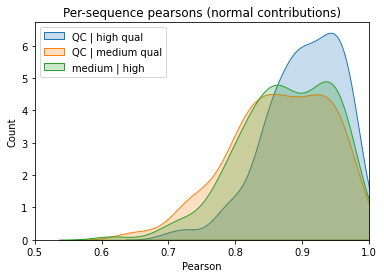

--- Extended contributions ---
0.9187194977360263 0.732313148220967
0.8869427779334724 0.6882707717491116
0.8952891949894962 0.6560756086783341


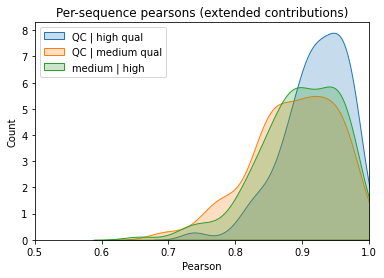

In [115]:
plt.figure(figsize=(6,4))
for key in result_dict.keys():
    #print(key)
    all_pearsons = []
    for seq_idx in range(test_size):
        for cell_idx in range(3):
            x = result_dict[key][cell_idx, seq_idx, ...].flatten().numpy()
            y = test_scores[cell_idx, seq_idx, ...].flatten().numpy()
            pearson = np.corrcoef(x,y)[0,1]
            all_pearsons.append(pearson)       
    print(np.mean(all_pearsons), np.min(all_pearsons))
    label = 'QC | ' + key.split(' ')[1] + ' qual'
    sns.kdeplot(all_pearsons, label=label, alpha=0.25, fill=True)
# plt.title(f'Per-sequence pearsons (extended contributions)')
# plt.legend()
# plt.show()



all_pearsons = []
for seq_idx in range(test_size):
    for cell_idx in range(3):
        x = result_dict['Standard high quality'][cell_idx, seq_idx, ...].flatten().numpy()
        y = result_dict['Standard medium quality'][cell_idx, seq_idx, ...].flatten().numpy()
        pearson = np.corrcoef(x,y)[0,1]
        all_pearsons.append(pearson)       
print(np.mean(all_pearsons), np.min(all_pearsons))
sns.kdeplot(all_pearsons, label='medium | high', alpha=0.25, fill=True)

plt.title(f'Per-sequence pearsons (normal contributions)')
plt.legend(loc='upper left')
plt.xlim(0.5, 1)
plt.xlabel('Pearson')
plt.ylabel('Count')
plt.show()

print('--- Extended contributions ---')

plt.figure(figsize=(6,4))
for key in result_dict.keys():
    #print(key)
    all_pearsons = []
    for seq_idx in range(test_size):
        for cell_idx in range(3):
            x = result_dict[key][cell_idx, seq_idx, ...]* test_batch[seq_idx, ...]
            x = x.sum(dim=0).flatten().numpy()
            y = test_scores[cell_idx, seq_idx, ...]* test_batch[seq_idx, ...]
            y = y.sum(dim=0).flatten().numpy()
            pearson = np.corrcoef(x,y)[0,1]
            all_pearsons.append(pearson)       
    print(np.mean(all_pearsons), np.min(all_pearsons))
    label = 'QC | ' + key.split(' ')[1] + ' qual'
    sns.kdeplot(all_pearsons, label=label, alpha=0.25, fill=True)
# plt.title(f'Per-sequence pearsons (extended contributions)')
# plt.legend()
# plt.show()

all_pearsons = []
for seq_idx in range(test_size):
    for cell_idx in range(3):
        x = result_dict['Standard high quality'][cell_idx, seq_idx, ...]* test_batch[seq_idx, ...]
        x = x.sum(dim=0).flatten().numpy()
        y = result_dict['Standard medium quality'][cell_idx, seq_idx, ...]* test_batch[seq_idx, ...]
        y = y.sum(dim=0).flatten().numpy()
        pearson = np.corrcoef(x,y)[0,1]
        all_pearsons.append(pearson)       
print(np.mean(all_pearsons), np.min(all_pearsons))
sns.kdeplot(all_pearsons, label='medium | high', alpha=0.25, fill=True)

plt.title(f'Per-sequence pearsons (extended contributions)')
plt.legend(loc='upper left')
plt.xlim(0.5, 1)
plt.xlabel('Pearson')
plt.ylabel('Count')
plt.show()

30 2


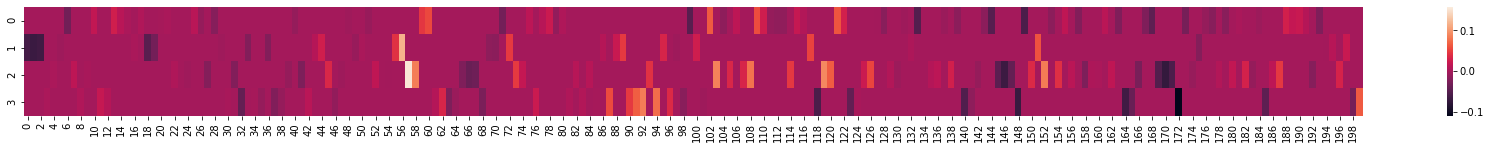

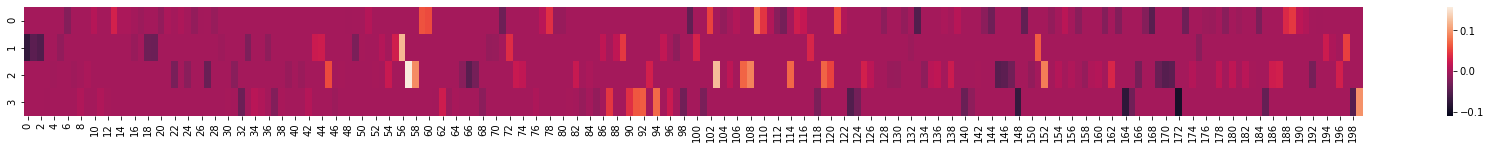

39 2


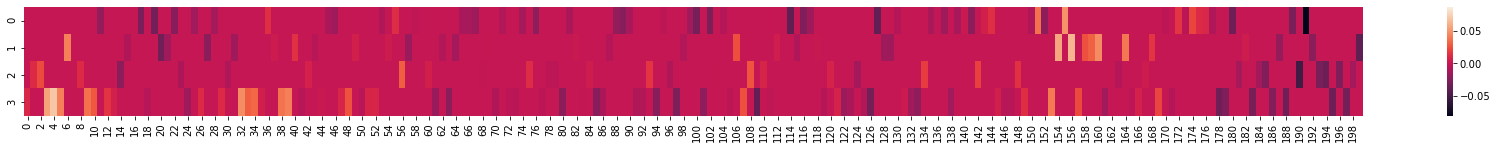

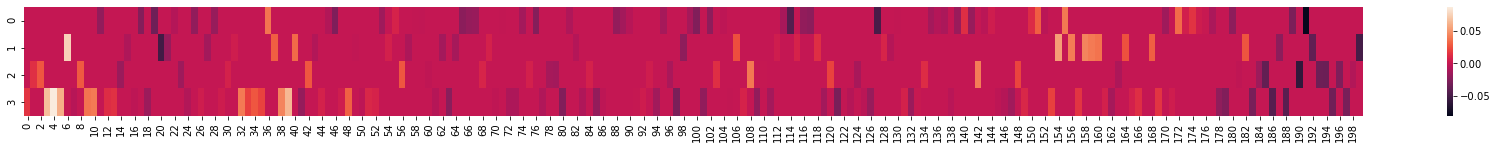

42 0


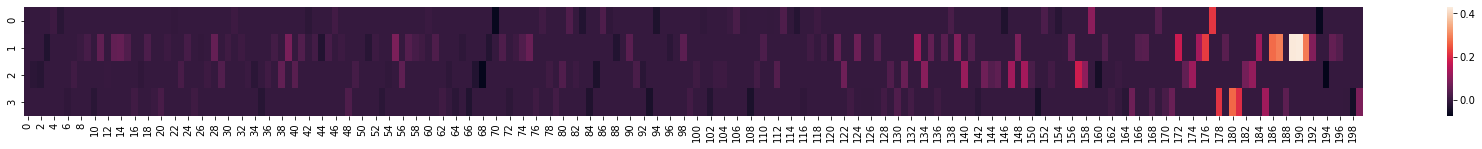

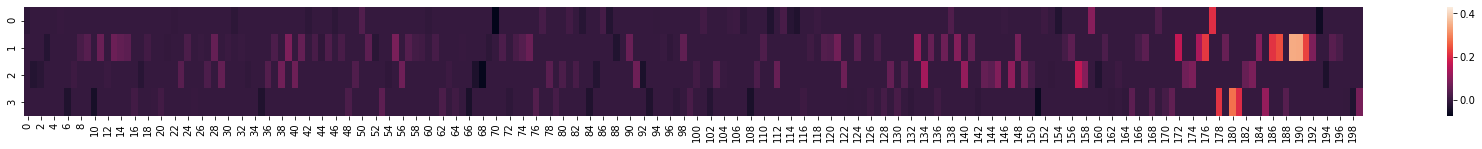

21 0


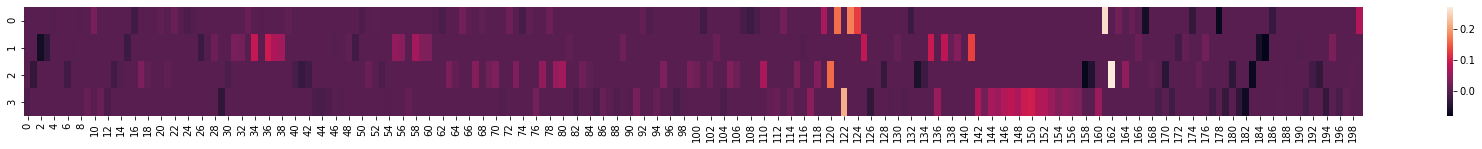

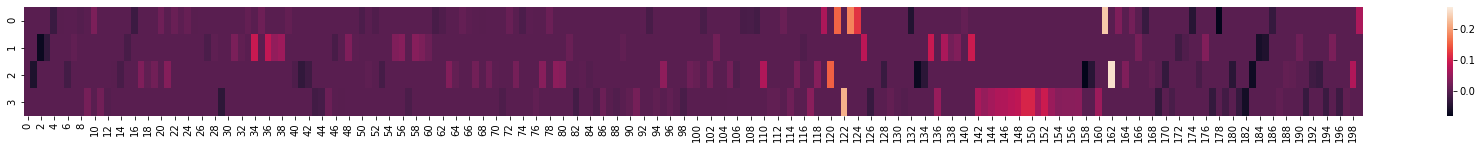

32 2


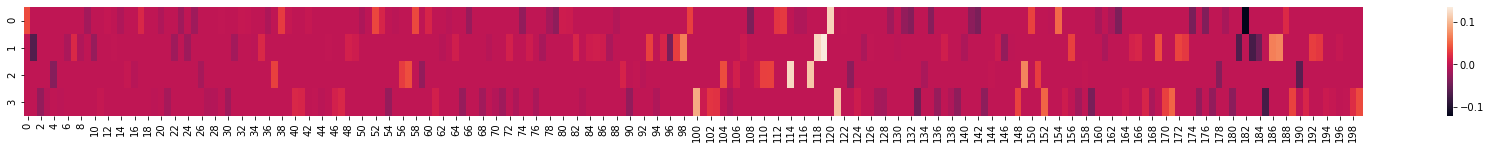

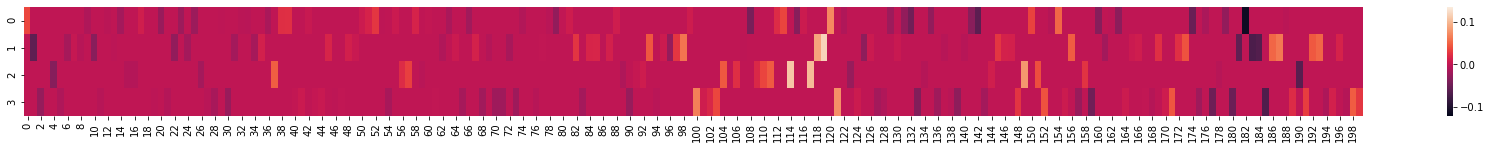

In [105]:
for i in range(5):  
    seq_idx = random.randrange(test_size)
    cell_idx = random.randrange(3)
    print(seq_idx, cell_idx)

    x = result_dict['Standard high quality'][cell_idx, seq_idx, ...] * test_batch[seq_idx, ...]
    y = test_scores[cell_idx, seq_idx, ...] * test_batch[seq_idx, ...]
    y_max = max(x.max(), y.max())
    y_min = min(x.min(), y.min())

    plt.figure(figsize=(30,2))
    sns.heatmap(x, vmin=y_min, vmax=y_max)
    plt.show()

    plt.figure(figsize=(30,2))
    sns.heatmap(y, vmin=y_min, vmax=y_max)
    plt.show()

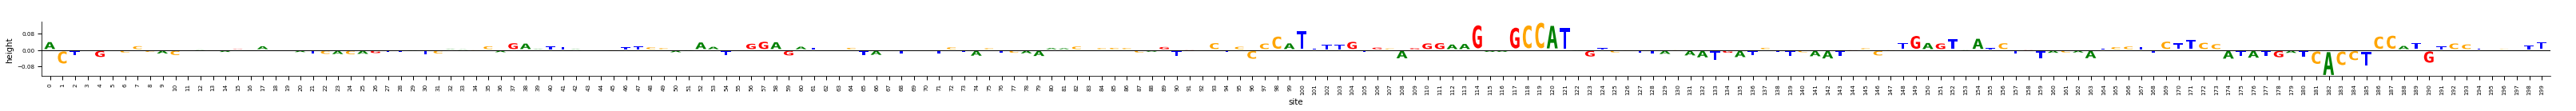

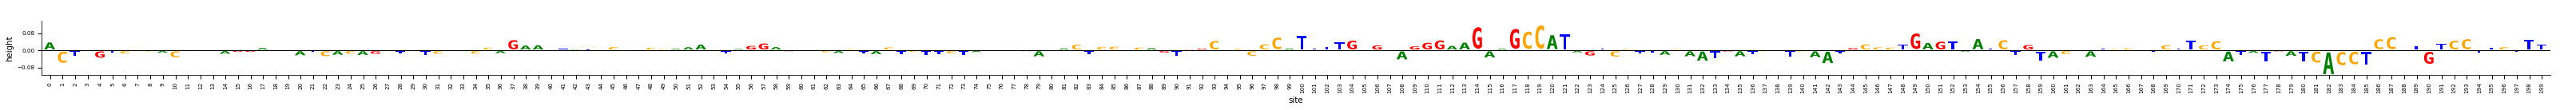

In [106]:
matrix_to_dms(x, y_max=y_max)
plt.show()            
matrix_to_dms(y, y_max=y_max)
plt.show()